<a href="https://colab.research.google.com/github/bonly/AI/blob/main/quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install akshare --upgrade

In [51]:
import akshare as ak;
from pprint import pprint;

help(ak.stock_zh_index_daily_tx)
# pprint(dir(ak.stock_zh_index_daily_tx))
# pprint(ak.__dict__)

Help on function stock_zh_index_daily_tx in module akshare.index.index_stock_zh:

stock_zh_index_daily_tx(symbol: str = 'sz980017') -> pandas.core.frame.DataFrame
    腾讯证券-日频-股票或者指数历史数据
    作为 ak.stock_zh_index_daily() 的补充, 因为在新浪中有部分指数数据缺失
    注意都是: 前复权, 不同网站复权方式不同, 不可混用数据
    https://gu.qq.com/sh000919/zs
    :param symbol: 带市场标识的股票或者指数代码
    :type symbol: str
    :return: 前复权的股票和指数数据
    :rtype: pandas.DataFrame



In [ ]:

his = ak.stock_zh_a_hist(symbol="000001", period="daily", start_date="20170301", end_date='20240528', adjust="");
pprint(his.head);


In [ ]:
minute_df = ak.stock_zh_a_minute(symbol='sh000300', period='5')
pprint(minute_df.tail)

In [58]:
# pprint(dir(ak));
data = ak.stock_zh_a_minute(symbol='sz300188', period='1')

In [60]:
pprint(data.tail(10));

                      day    open    high     low   close   volume
1960  2025-08-14 14:49:00  19.410  19.420  19.350  19.350   290500
1961  2025-08-14 14:50:00  19.350  19.350  19.300  19.300   230100
1962  2025-08-14 14:51:00  19.300  19.310  19.190  19.200   297800
1963  2025-08-14 14:52:00  19.200  19.200  19.050  19.060   380500
1964  2025-08-14 14:53:00  19.050  19.060  18.980  18.980   620100
1965  2025-08-14 14:54:00  18.980  19.030  18.960  19.030   616067
1966  2025-08-14 14:55:00  19.030  19.160  19.020  19.150   485400
1967  2025-08-14 14:56:00  19.150  19.210  19.100  19.110   423800
1968  2025-08-14 14:57:00  19.100  19.120  19.060  19.080   555100
1969  2025-08-14 15:00:00  19.080  19.080  19.080  19.080  1016699


In [61]:
import numpy as np
import pandas as pd # 导入 pandas

# help(np.log);
# pprint(dir(data));

# 将 'close' 列转换为数值类型，errors='coerce' 会将无法转换的值设为 NaN
data['close'] = pd.to_numeric(data['close'], errors='coerce')

# 计算对数收益率，使用自然对数 np.log
data['r'] = np.log(data['close'] / data['close'].shift(1))

cols = []
for momentum in [15, 30, 60, 120, 150]:
    col = f'p_{momentum}'  #为当前动量周期创建一个列名字符串 f''是格式化字符串
    # 计算每个滚动窗口内对数收益率的平均值，并取符号
    data[col] = np.sign(data['r'].rolling(momentum).mean())
    cols.append(col)

代码旨在 DataFrame 中创建几个新列，每个列代表不同回溯周期的动量指标。

data[col] = np.sign(data['r'].rolling(momentum).mean()): 这一行计算当前周期的动量指标。

  * data['r'].rolling(momentum): 这会将指定 momentum 大小的滚动窗口应用于对数收益率列（r）。

  * .mean(): 这会计算每个滚动窗口内对数收益率的平均值。

  * np.sign(...): 这会取计算出的平均值的符号。np.sign 函数对于正值返回 1，对于负值返回 -1，对于零返回 0。这有效地创建了一个动量指标，当该周期的平均收益率为正时为 1，为负时为 -1，否则为 0。

In [62]:
pprint(data.columns)
pprint(data.tail(10))
pprint(cols);

Index(['day', 'open', 'high', 'low', 'close', 'volume', 'r', 'p_15', 'p_30',
       'p_60', 'p_120', 'p_150'],
      dtype='object')
                      day    open    high     low  close   volume         r  \
1960  2025-08-14 14:49:00  19.410  19.420  19.350  19.35   290500 -0.003611   
1961  2025-08-14 14:50:00  19.350  19.350  19.300  19.30   230100 -0.002587   
1962  2025-08-14 14:51:00  19.300  19.310  19.190  19.20   297800 -0.005195   
1963  2025-08-14 14:52:00  19.200  19.200  19.050  19.06   380500 -0.007318   
1964  2025-08-14 14:53:00  19.050  19.060  18.980  18.98   620100 -0.004206   
1965  2025-08-14 14:54:00  18.980  19.030  18.960  19.03   616067  0.002631   
1966  2025-08-14 14:55:00  19.030  19.160  19.020  19.15   485400  0.006286   
1967  2025-08-14 14:56:00  19.150  19.210  19.100  19.11   423800 -0.002091   
1968  2025-08-14 14:57:00  19.100  19.120  19.060  19.08   555100 -0.001571   
1969  2025-08-14 15:00:00  19.080  19.080  19.080  19.08  1016699  0.000000  

In [63]:
from pylab import plt  #图表库
plt.style.use('seaborn-v0_8') #设置图表视觉风格
%config InlineBackend.figure_format = 'svg' #配置jupyter或colab环境中内联显示图表的格式


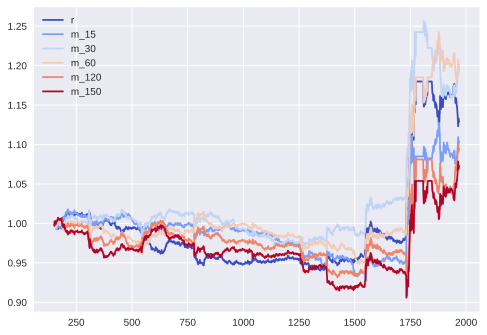

In [64]:
strats = ['r'];  #初始化一个名为 strats 的列表，并将字符串 'r' 添加进去。'r' 代表之前计算的对数收益率，作为比较的基础策略（即持有策略）。
for col in cols: #循环遍历之前在 cols 列表中存储的动量指标列名（例如，'p_15', 'p_30' 等）。
    strat = f'm_{col[2:]}'; #对于每个动量列名，创建一个新的策略列名。col[2:] 取出列名中 'p_' 后面的数字（例如，从 'p_15' 中取出 '15'），
                 #然后使用 f-string 将其格式化为 'm_数字'（例如，'m_15'）。这个新的列名代表基于该动量指标的交易策略。
    data[strat] = data[col].shift(1) * data['r'];
    strats.append(strat); #将新创建的策略列名添加到 strats 列表中
data[strats].dropna().cumsum().apply(np.exp).plot(cmap='coolwarm');

* data[col].shift(1): 这会获取当前动量指标列 (col) 向上移动一行（即前一个时间点）的值。这模拟了在当前时间点根据前一个时间点的动量信号进行交易决策。如果前一个时间点的动量指标是 1（看涨），则为 1；如果是 -1（看跌），则为 -1；如果是 0，则为 0。

  * data['r']: 这将前一个时间点的动量信号与当前时间点的对数收益率相乘。

    * 如果前一个时间点的动量信号是 1（看涨），则策略收益率等于当前的对数收益率（买入并持有）。
    * 如果前一个时间点的动量信号是 -1（看跌），则策略收益率等于当前的对数收益率乘以 -1（做空并获利或亏损）。
    * 如果前一个时间点的动量信号是 0，则策略收益率等于 0（不进行交易）。

* data[strats].dropna().cumsum().apply(np.exp).plot(cmap='coolwarm'): 这行代码用于绘制所有策略的累积收益率图表。

   * data[strats]: 选取 data DataFrame 中所有在 strats 列表中的列（原始收益率 'r' 和所有动量策略收益率）。
   * .dropna(): 删除包含 NaN 值的行。这是必要的，因为滚动计算和 shift 操作会在数据开头产生 NaN 值。
   * .cumsum(): 计算每一列的累积和。对于对数收益率，累积和代表对数空间的累积收益。
   * .apply(np.exp): 对累积和应用指数函数 (np.exp)。这将对数空间的累积收益转换回线性空间的累积收益率（即，如果初始投资为 1，累积收益率表示最终的资产价值）。
   * .plot(cmap='coolwarm')：使用 Matplotlib 绘制累积收益率。cmap='coolwarm' 设置了图表的颜色映射，使得不同的策略曲线颜色有所区别。



代码的核心思想是根据不同周期的动量指标生成交易信号（买入、卖出或观望），

然后计算基于这些信号的交易策略在每个时间点的收益率，

并最终绘制出这些策略随时间发展的累积收益率曲线，

以便与简单的持有策略进行比较。